In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import pynrc

from pynrc import nrc_utils
from pynrc import nircam_dark
from pynrc.detops import create_detops

from pynrc.reduce import calib, ref_pixels
from pynrc.reduce.calib import find_sat, cube_fit

from webbpsf_ext import robust
from webbpsf_ext.maths import jl_poly, jl_poly_fit, hist_indices, binned_statistic, fit_bootstrap

from pynrc.reduce.calib import chisqr_red, get_fits_data, ramp_derivative, get_nonlinear_coeffs
from pynrc.reduce.calib import time_to_sat, find_group_sat, calc_nonlin_coeff, gen_super_ramp
from pynrc.simul.ngNRC import sim_image_ramp, apply_nonlin

In [3]:
from astropy.io import fits
import gc

# NIRCam Dark Info

In [4]:
# Init NIRCam dark
darkdir = '/Users/jarron/NIRCam/Data/CV3_Darks/'
lindir = '/Users/jarron/NIRCam/Data/CV3_Linearity/'
outdir = '/Users/jarron/NIRCam/dark_analysis/CV3/'
dark_data = nircam_dark(485, darkdir, outdir, lindir=lindir)

# Dark slope and bias images
dark_data.get_dark_slope_image()
dark_data.get_super_bias_update()

# Get IPC/PPC kernels
dark_data.get_ipc(calc_ppc=True)

# Deconvolve the super dark and super bias images
dark_data.deconvolve_supers()

[     pynrc:INFO] RAPID readout mode selected.
[     pynrc:INFO] Setting ngroup=108, nf=1, nd1=0, nd2=0, nd3=0.
[     pynrc:INFO] Initializing SCA 485/A5
[     pynrc:INFO] Calculating dark slope image...
[     pynrc:INFO] Generating initial super bias
[     pynrc:INFO] Opening updated super bias
[     pynrc:INFO] Calculating IPC and PPC kernels...
[     pynrc:INFO]   IPC = 0.597% +/- 0.004%
[     pynrc:INFO]   PPC = 0.123% +/- 0.010%
[     pynrc:INFO] Deconvolving super dark and super bias images...


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/1 [00:00<?, ?it/s]

# NIRCam Linearity Data

In [5]:
dark_data.get_nonlinear_coeffs()

[     pynrc:INFO] Loading non-linearity coefficents


In [6]:
coeff_dict = dark_data.nonlinear_dict

cf_nonlin      = coeff_dict.get('cf_nonlin')
cf_nonlin_low  = coeff_dict.get('cf_nonlin_low')
sat_vals       = coeff_dict.get('sat_vals')

print(cf_nonlin[:,100,100], cf_nonlin_low[:,100,100])

[1.60112996 0.46548607 0.29461327 0.35967238 0.18675153 0.20381732
 0.05967958 0.05214238] [-237067.69179916 -566794.10994094 -595208.59033572 -407840.24243685
 -193119.18346058  -61822.21127326  -12189.02526868   -1129.35384728]


In [7]:
# Header info
allfiles = dark_data.linfiles
hdr = fits.getheader(allfiles[0])

DMS=False
det = create_detops(hdr, DMS=DMS)

[     pynrc:INFO] RAPID readout mode selected.
[     pynrc:INFO] Setting ngroup=190, nf=1, nd1=0, nd2=0, nd3=0.
[     pynrc:INFO] Initializing SCA 485/A5


In [8]:
# Dimensions
nz, ny, nx = (det.multiaccum.ngroup, det.ypix, det.xpix)
nchan = det.nout
chsize = int(nx / nchan)

# Time array
tarr = det.times_group_avg

In [9]:
kwargs_ref = {
    'nchans': nchan, 'in_place': True, 'altcol': True,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False,
}

data, _ = gen_super_ramp(allfiles[1:5], super_bias=dark_data.super_bias, sat_vals=sat_vals, **kwargs_ref)

# Update number of read frames
nz, ny, nx = data.shape
det.multiaccum.ngroup = nz
tarr = det.times_group_avg

Super Ramp:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
# IPC and PPC kernels
kppc = dark_data.kernel_ppc
kipc = dark_data.kernel_ipc

# PPC corrections
if kppc[1,2]>0:
    data = calib.ppc_deconvolve(data, kppc)

# IPC correction
data = calib.ipc_deconvolve(data, kipc)

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/75 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/75 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/75 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/75 [00:00<?, ?it/s]

IPC Frames:   0%|          | 0/75 [00:00<?, ?it/s]

In [11]:
# Well level in electrons
well_depth = det.well_level

In [ ]:
sat_vals = find_sat(data)

In [132]:
cf_arr = cube_fit(tarr, data, deg=2, sat_vals=sat_vals, sat_frac=0.5, fit_zero=False)

0.06183439154231127


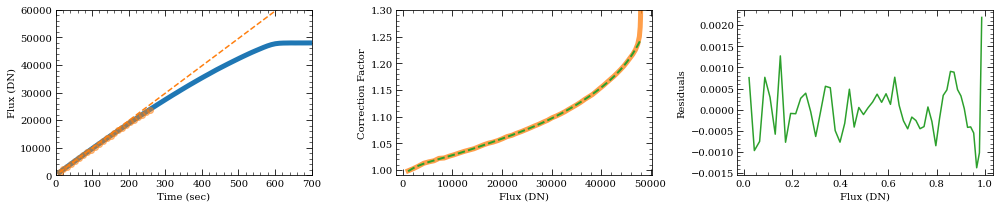

In [219]:
fig, axes = plt.subplots(1,3, figsize=(14,3))

ix, iy = (100,100)

ax = axes[0]
yvals = data[:,iy,ix]
ax.plot(tarr, yvals, lw=5)
ax.plot(tarr[yvals<24000], yvals[yvals<24000], ls='none', marker='o', color='C1', alpha=0.5)

yfit = jl_poly(tarr, cf_arr[:2,iy,ix])
ax.plot(tarr, yfit, ls='--')

ax.set_xlabel('Time (sec)')
ax.set_ylabel('Flux (DN)')

ax.set_xlim([0,700])
ax.set_ylim([0,60000])


ax=axes[1]
frac_nonlin = yfit / yvals
ax.plot(yvals, frac_nonlin, lw=5, color='C1', alpha=0.75)

ifit = yvals<0.99*sat_vals[iy,ix]
cf = jl_poly_fit(yvals[ifit], frac_nonlin[ifit], deg=7)
frac_fit = jl_poly(yvals, cf)
ax.plot(yvals, frac_fit, color='C2', lw=2, ls='--')


ax.set_xlabel('Flux (DN)')
ax.set_ylabel('Correction Factor')

ax.set_ylim([0.99,1.3])


ax = axes[2]
diff = (frac_nonlin - frac_fit)
ind = frac_nonlin < 1.24
ax.plot(yvals[ind], diff[ind], color='C2')

print(np.std(diff[ind])* 100) 

ax.set_xlabel('Flux (DN)')
ax.set_ylabel('Residuals')


fig.tight_layout()

Text(0, 0.5, 'Systematic uncertainty / Poisson noise')

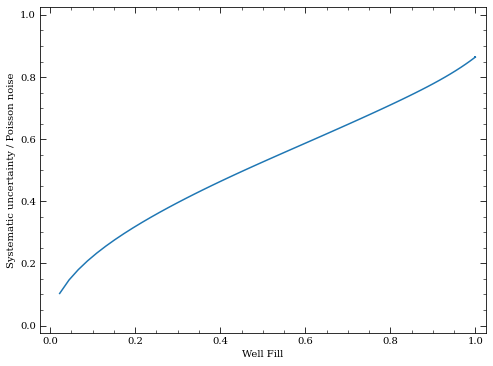

In [218]:
cfact_nom = frac_fit
cfact_off = frac_fit * 1.003

yvals_corr_nom = yvals * cfact_nom
yvals_corr_off = yvals * cfact_off

gain = 83000 / yvals_corr_nom.max()
yvals_corr_nom *= gain
yvals_corr_off *= gain

diff = yvals_corr_off - yvals_corr_nom
# plt.plot(yvals, yvals_ocrr_off)
plt.plot(yvals/yvals.max(), diff/np.sqrt(83000*yvals/yvals.max()))

plt.ylim([-0.025,1.025])
plt.xlim([-0.025,1.025])

plt.xlabel('Well Fill')
plt.ylabel('Systematic uncertainty / Poisson noise')

## Simulated Data

In [14]:
# Create simulated ideal ramp
from copy import deepcopy

det_new = deepcopy(det)

# Get saturation times and assumed well depths
tsat = time_to_sat(data, sat_vals, dt=det_new.time_group)
well_depth_dn = well_depth / det_new.gain

# Create a slope
im_slope = well_depth_dn / tsat # DN/sec
im_slope[~np.isfinite(im_slope)] = 0
ramp = sim_image_ramp(det_new, im_slope)

tarr_new = det_new.times_group_avg

In [15]:
gc.collect()

157

In [37]:
coeff_dict = dark_data.nonlinear_dict

cf_nonlin      = coeff_dict.get('cf_nonlin')

cflin0_mean    = coeff_dict.get('cflin0_mean')
cflin0_std     = coeff_dict.get('cflin0_std')
corr_slope     = coeff_dict.get('corr_slope')
corr_intercept = coeff_dict.get('corr_intercept')

use_legendre   = coeff_dict.get('use_legendre')
lxmap          = coeff_dict.get('lxmap')
deg            = coeff_dict.get('deg')

counts_cut     = coeff_dict.get('counts_cut')
cf_nonlin_low  = coeff_dict.get('cf_nonlin_low')

sat_vals       = coeff_dict.get('sat_vals')

In [38]:
cf_nonlin[:,100,100]

array([1.60112996, 0.46548607, 0.29461327, 0.35967238, 0.18675153,
       0.20381732, 0.05967958, 0.05214238])

In [39]:
cf_nonlin_low[:,100,100]

array([-237067.69179916, -566794.10994094, -595208.59033572,
       -407840.24243685, -193119.18346058,  -61822.21127326,
        -12189.02526868,   -1129.35384728])

In [42]:
%time test = apply_nonlin(ramp, det_new, coeff_dict, randomize=True)

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

CPU times: user 54.6 s, sys: 7.5 s, total: 1min 2s
Wall time: 1min 2s


In [24]:
xpix, ypix = (1000,100)

pval = ramp[:,ypix,xpix].reshape([-1,1,1])
sval = sat_vals[ypix,xpix].reshape([1,1])

coeff_dict = {
    'cf_nonlin'      : cf_nonlin[:,ypix,xpix].reshape([-1,1,1]),
    'cflin0_mean'    : cflin0_mean[ypix,xpix].reshape([-1,1]),
    'cflin0_std'     : cflin0_std[ypix,xpix].reshape([-1,1]),
    'corr_slope'     : corr_slope[:,ypix,xpix].reshape([-1,1,1]),
    'corr_intercept' : corr_intercept[:,ypix,xpix].reshape([-1,1,1]),
    'use_legendre'   : use_legendre,
    'lxmap'          : lxmap,
    'counts_cut'     : counts_cut,
    'cf_nonlin_low'  : cf_nonlin_low[:,ypix,xpix].reshape([-1,1,1]),
    'sat_vals'       : sat_vals[ypix,xpix].reshape([-1,1]),
}

pix_all = []
for i in trange(10):    
    test = apply_nonlin(pval, det_new, coeff_dict, randomize=True)
    
    pix = test.flatten()
    pix_all.append(pix)

  0%|          | 0/10 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

Frames:   0%|          | 0/75 [00:00<?, ?it/s]

45895.35727691054


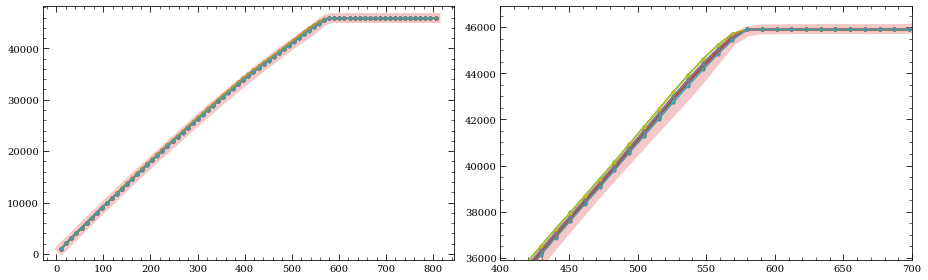

In [25]:
fig, axes = plt.subplots(1,2, figsize=(13,4))

for ax in axes:
    for pix in pix_all:    
        ax.plot(tarr_new, pix, marker='.')
    ax.plot(tarr, data[:,ypix,xpix], lw=10, color='C3', alpha=0.25)

sval = sat_vals[ypix,xpix]
print(sval)

# plt.plot(tvals, np.ones_like(tvals)*sval, ls='--')

# gain = jl_poly(pix[:,0], coeff[:,0], use_legendre=use_legendre, lxmap=lxmap)
# plt.plot(tvals, pix[:,0] / gain)

axes[1].set_xlim([400,700])
axes[1].set_ylim([sval-10000,sval+1000])

# axes[1].set_xlim([0,250])
# axes[1].set_ylim([0,20000])


fig.tight_layout()

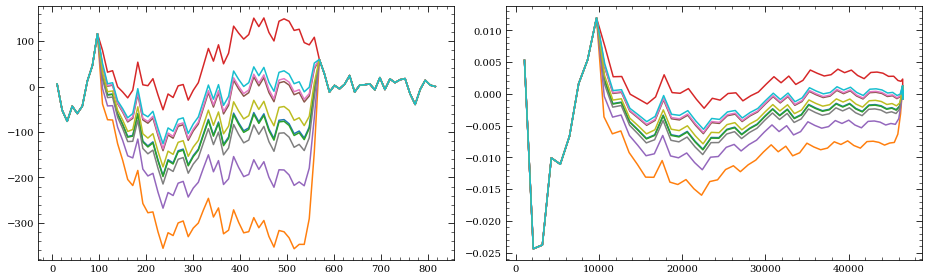

In [26]:
fig, axes = plt.subplots(1,2, figsize=(13,4))

ax = axes[0]
for pix in pix_all:    
    ax.plot(tarr_new, (pix-data[:,ypix,xpix]))

ax = axes[1]
for pix in pix_all:    
    ax.plot(pix, (pix-data[:,ypix,xpix])/pix)


fig.tight_layout()